In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path="/content/drive/MyDrive/Research/Hard_Attention/dataset_2/m_5_size_100/run_"

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/hard_attention')

# Generate dataset

In [5]:
np.random.seed(1)

y = np.concatenate((np.zeros(500),np.ones(500),np.ones(500)*2,np.ones(500)*3,np.ones(500)*4,
                    np.ones(500)*5,np.ones(500)*6,np.ones(500)*7,np.ones(500)*8,np.ones(500)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500
4 500
5 500
6 500
7 500
8 500
9 500


In [6]:
x = np.zeros((5000,2))

In [7]:
np.random.seed(12)

x[idx[0],:] = np.random.multivariate_normal(mean = [4,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [5.5,6],cov=[[0.01,0],[0,0.01]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [4.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [3,3.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [2.5,5.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [3.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [5.5,8],cov=[[0.01,0],[0,0.01]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [7,6.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [6.5,4.5],cov=[[0.01,0],[0,0.01]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [5,3],cov=[[0.01,0],[0,0.01]],size=sum(idx[9]))

In [8]:
x[idx[0]][0], x[idx[2]][5] 

(array([4.04729858, 6.43185741]), array([4.53008447, 4.5079931 ]))

In [9]:
print(x.shape,y.shape)

(5000, 2) (5000,)


In [10]:
idx= []
for i in range(10):
  idx.append(y==i)

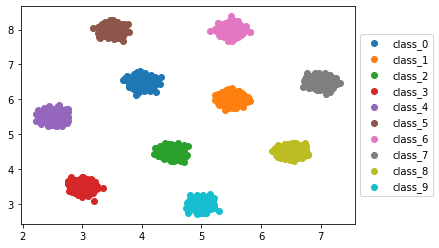

In [11]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
x = ( x -  np.mean(x,axis=0,keepdims=True) ) / np.std(x,axis=0,keepdims=True) 


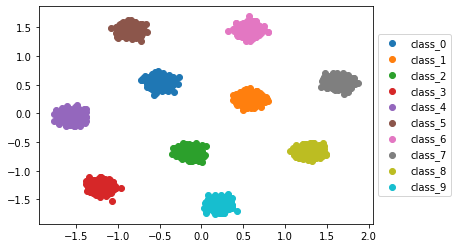

In [13]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [15]:
desired_num = 3000
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,10)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,2)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 3000/3000 [00:04<00:00, 631.78it/s]


In [16]:
# mosaic_list_of_images = np.concatenate(mosaic_list_of_images,axis=1).T


In [17]:
len(mosaic_list_of_images), mosaic_list_of_images[0],mosaic_list_of_images[0].shape

(3000,
 array([[ 1.41860713, -0.6338838 ],
        [ 0.60177752,  1.40622261],
        [ 0.64672986,  1.41882828],
        [-1.69776679, -0.08130752],
        [ 1.27946811, -0.71643805],
        [ 1.45704   ,  0.60485745],
        [ 0.18423713, -1.55664656],
        [-1.22655811, -1.21367441],
        [-0.91172816,  1.57430636],
        [ 0.15127428, -1.62296362],
        [ 0.1344424 , -1.55689301],
        [-1.69472731, -0.13317729],
        [-1.48633975, -0.11413025],
        [-1.28089583, -1.35206685],
        [ 1.65185875,  0.62351016],
        [-1.15951149, -1.22729989],
        [ 1.38896738, -0.56645068],
        [-1.18761801, -1.25787568],
        [ 0.61278208,  1.60577174],
        [-1.69274759, -0.07362477],
        [ 1.39540616, -0.70341419],
        [ 0.6484437 ,  1.36911164],
        [-1.19959749, -1.37680104],
        [-1.64713463, -0.03977351],
        [-1.28776671, -1.24072576],
        [-0.91020867,  1.53719333],
        [ 0.61165152,  1.3779105 ],
        [-0.84921877,

In [18]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]



In [19]:
batch = 50
msd1 = MosaicDataset(mosaic_list_of_images[0:2000], mosaic_label[0:2000] , fore_idx[0:2000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [20]:
data,_,_=iter(train_loader).next()

In [21]:
data.shape

torch.Size([50, 100, 2])

In [22]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[2000:], mosaic_label[2000:] , fore_idx[2000:])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

In [23]:
class Focus(nn.Module):
    def __init__(self):
        super(Focus, self).__init__()
        self.fc1 = nn.Linear(2,50, bias=False)
        self.fc2 = nn.Linear(50,1,bias=False)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        #self.fc2 = nn.Linear(64, 1, bias=False)
        #torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self,z):
        #print("data",z)
        batch = z.size(0)
        patches = z.size(1)
        z = z.view(batch,patches,2*1)
        alp1,ft1 = self.helper(z)

        alpha = F.softmax(alp1,dim=1)
        #print(self.training)
        
        if self.training:
            alpha =alpha[:,:,0]
            y = ft1 
            return alpha,y
        else:
            #alpha_cumsum = torch.cumsum(alpha, dim = 1)
            #print(alpha_cumsum)
            #len_batch = alpha_cumsum.size(0)
            #patches = alpha_cumsum.size(1)
            #rand_prob = torch.rand(len_batch,patches, 1).to(device)
            #alpha_relu = F.relu(rand_prob-alpha_cumsum)
            #print(alpha_relu)
            #alpha_index = torch.count_nonzero(alpha_relu,dim=1)
            #alpha_hard = F.one_hot(alpha_index,num_classes=patches)
            #print(alpha_hard)
            #alpha_hard = torch.transpose(alpha_hard,dim0=1,dim1=2)
            #print(ft1,"alpha_hard",alpha_hard) 
            #y = torch.sum(alpha_hard*ft1,dim=1)
            #print(alpha,alpha.shape)
         
        
            index = torch.argmax(alpha,dim=1)
            hard_alpha = torch.nn.functional.one_hot(index[:,0], patches)
            y = torch.sum(hard_alpha[:,:,None]*ft1,dim=1)
            alpha = alpha[:,:,0]
            return alpha,y
    
    def helper(self, x):
        x1 = x
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x,x1

In [24]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(2, 3)
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

  def forward(self, x):
    #print(x.shape)
    #x = x.view(-1, 1)
    #print(x.shape)
    x = self.fc1(x)
    # print(x.shape)
    return x

In [25]:
torch.manual_seed(12)
focus_net = Focus().double()
focus_net = focus_net.to(device)

In [26]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to(device)

In [27]:
import torch.optim as optim
optimizer_classify = optim.Adam(classify.parameters(), lr=0.01 ) #, momentum=0.9)
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.01 ) #, momentum=0.9)

In [28]:
def my_cross_entropy(output,target,alpha):
    criterion = nn.CrossEntropyLoss(reduce=False)
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    
    
    
    output = torch.reshape(output,(batch*patches,classes))
    
    
    target = target.repeat_interleave(patches)
    
    loss = criterion(output,target)
    
    #print(loss,loss.shape)
    loss = torch.reshape(loss,(batch,patches))
    #print(loss.size())
    final_loss = torch.sum(torch.mul(loss,alpha),dim=1)
    #print(final_loss.shape)
    final_loss = torch.mean(final_loss,dim=0)
    
    
    
    #print(final_loss)
    return final_loss
    
    
    

In [29]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

In [30]:
def plot_attended_data(trainloader,net,epoch):
    attd_data =[]
    lbls = []
    for data in trainloader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
        alphas, avg_images = focus_net(inputs)
        attd_data.append(avg_images.numpy())
        lbls.append(labels)
    attd_data = np.concatenate(attd_data,axis=0)
    lbls = np.concatenate(lbls,axis=0)
    plt.figure(figsize=(6,8))
    plt.scatter(attd_data[:,0],attd_data[:,1],c=lbls)
    plt.title("EPOCH_"+str(epoch))

In [31]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    loss = my_cross_entropy(outputs,labels,alphas)
    print(loss)
    # print(outputs.shape)
    _, predicted = torch.max(outputs.data, 1)


print("="*100)



/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor(1.1843, dtype=torch.float64)
tensor(1.1874, dtype=torch.float64)
tensor(1.1941, dtype=torch.float64)
tensor(1.1978, dtype=torch.float64)
tensor(1.1853, dtype=torch.float64)
tensor(1.1960, dtype=torch.float64)
tensor(1.1872, dtype=torch.float64)
tensor(1.2060, dtype=torch.float64)
tensor(1.1824, dtype=torch.float64)
tensor(1.1914, dtype=torch.float64)
tensor(1.1843, dtype=torch.float64)
tensor(1.1921, dtype=torch.float64)
tensor(1.1980, dtype=torch.float64)
tensor(1.1841, dtype=torch.float64)
tensor(1.2030, dtype=torch.float64)
tensor(1.1993, dtype=torch.float64)
tensor(1.1884, dtype=torch.float64)
tensor(1.1941, dtype=torch.float64)
tensor(1.1745, dtype=torch.float64)
tensor(1.1848, dtype=torch.float64)
tensor(1.1835, dtype=torch.float64)
tensor(1.1977, dtype=torch.float64)
tensor(1.1827, dtype=torch.float64)
tensor(1.1995, dtype=torch.float64)
tensor(1.1904, dtype=torch.float64)
tensor(1.1963, dtype=torch.float64)
tensor(1.1877, dtype=torch.float64)
tensor(1.1834, dtype=torch.f

In [32]:
correct = 0
total = 0
count = 0
flag = 1


with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to(device),labels.to(device), fore_idx.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)


In [33]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[-0.1235,  0.3437],
        [ 0.1704, -0.2588],
        [ 0.0472,  0.0784],
        [ 0.4953, -0.1659],
        [ 0.3371,  0.3451],
        [ 0.3131, -0.1927],
        [-0.1788,  0.0314],
        [ 0.1934,  0.0747],
        [-0.0699,  0.2935],
        [ 0.0524, -0.1017],
        [-0.2094, -0.3588],
        [ 0.2079, -0.0692],
        [-0.0396,  0.2914],
        [-0.2280,  0.0319],
        [-0.1798,  0.1602],
        [ 0.1488, -0.0822],
        [ 0.2434,  0.1657],
        [-0.1537, -0.0442],
        [-0.2106,  0.2442],
        [-0.1865, -0.1679],
        [-0.3746,  0.1089],
        [ 0.0765,  0.0746],
        [ 0.0194,  0.5148],
        [-0.0150, -0.0721],
        [-0.2615,  0.0124],
        [ 0.2550,  0.0677],
        [ 0.1783, -0.1196],
        [ 0.1869,  0.2055],
        [-0.0041, -0.1310],
        [-0.0923,  0.0208],
        [-0.1519, -0.2190],
        [-0.0142, -0.0720],
        [ 0.1204,  0.0586],
        [-0.2943,  0.2803],
        [ 0

In [34]:
nos_epochs = 2000
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0


for epoch in range(nos_epochs):  # loop over the dataset multiple times

  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    batch = inputs.size(0)
    inputs, labels = inputs.to(device), labels.to(device)
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = my_cross_entropy(outputs, labels,alphas) 
    
    loss.backward()
    
    
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 40
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  if(np.mean(epoch_loss) <= 0.01):
      break;
  #plot_attended_data(train_loader,focus_net,epoch)

    
print('Finished Training')

[1,    40] loss: 1.125
[2,    40] loss: 1.100
[3,    40] loss: 1.101
[4,    40] loss: 1.100
[5,    40] loss: 1.100
[6,    40] loss: 1.100
[7,    40] loss: 1.100
[8,    40] loss: 1.103
[9,    40] loss: 1.099
[10,    40] loss: 1.100
[11,    40] loss: 1.100
[12,    40] loss: 1.100
[13,    40] loss: 1.100
[14,    40] loss: 1.100
[15,    40] loss: 1.099
[16,    40] loss: 1.100
[17,    40] loss: 1.099
[18,    40] loss: 1.100
[19,    40] loss: 1.100
[20,    40] loss: 1.100
[21,    40] loss: 1.100
[22,    40] loss: 1.099
[23,    40] loss: 1.099
[24,    40] loss: 1.099
[25,    40] loss: 1.099
[26,    40] loss: 1.099
[27,    40] loss: 1.099
[28,    40] loss: 1.099
[29,    40] loss: 1.099
[30,    40] loss: 1.099
[31,    40] loss: 1.099
[32,    40] loss: 1.099
[33,    40] loss: 1.099
[34,    40] loss: 1.099
[35,    40] loss: 1.101
[36,    40] loss: 1.101
[37,    40] loss: 1.102
[38,    40] loss: 1.100
[39,    40] loss: 1.099
[40,    40] loss: 1.099
[41,    40] loss: 1.099
[42,    40] loss: 1.099
[

In [35]:
for param in focus_net.named_parameters():
    print(param)

('fc1.weight', Parameter containing:
tensor([[ 0.8796, -0.1927],
        [ 1.1915, -1.1198],
        [ 0.0521,  0.2010],
        [ 1.5337, -1.1656],
        [-0.7386,  0.9893],
        [ 0.2468, -0.3709],
        [ 0.0340,  0.0865],
        [ 0.6492, -0.2048],
        [ 0.2628,  1.3353],
        [ 0.9795,  0.8109],
        [-0.0725, -2.0085],
        [ 0.4513,  0.3526],
        [ 0.2773,  1.3291],
        [-1.2220,  0.6655],
        [-0.5197,  1.0594],
        [ 0.5013, -1.3342],
        [ 1.0358, -0.7126],
        [ 1.8835,  0.5846],
        [ 0.2953,  1.2162],
        [-1.3620, -1.3988],
        [-2.8255,  0.8382],
        [ 1.5621, -0.3729],
        [-0.6128,  1.1954],
        [-1.2049, -1.2747],
        [-0.1498,  0.3614],
        [-0.4942,  1.0758],
        [-1.1714, -1.1369],
        [ 0.0518,  0.1772],
        [-0.0381,  0.0243],
        [-0.3070,  0.6871],
        [-1.3197, -1.3054],
        [ 0.8911,  0.7068],
        [-0.0307,  0.0042],
        [ 0.3152,  1.4389],
        [ 0

In [36]:
correct = 0
total = 0

focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    #print(outputs.shape)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the train images: 100.000000 %
total correct 2000
total train set images 2000


In [37]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to(device), labels.to(device)
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the test images: 100.000000 %
total correct 1000
total train set images 1000
